### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import ipynb
import importlib

In [3]:
import ipynb.fs.full.modules.Config as config

In [4]:
importlib.reload(config)

<module 'ipynb.fs.full.modules.Config' (C:\Users\mliuzzolino\Desktop\bee_communication_v2\ipynb\modules\Config.ipynb)>

### Read Config File

In [6]:
# def read_config(base_exp_dir):
#     cfg_path = base_exp_dir + "/exp_1.cfg"
#     cfg_path, os.path.exists(cfg_path)

#     with open(cfg_path, "r") as infile:
#         lines = [line.split() for line in infile]
#         cfg_opts = {}
#         for key, val in lines:
#             key = key.replace('--', '')

#             try:
#                 val = float(val)
#             except:
#                 try:
#                     val = int(val)
#                 except:
#                     if val.startswith("T"):
#                         val = True
#                     elif val.startswith("F"):
#                         val = False
#                     pass
#             cfg_opts[key] = val
#     return cfg_opts

In [7]:
# base_exp_dir = "/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/script/experiments/cfg__exp_1__2019-01-12_21-34-53"
# config = read_config(base_exp_dir)

In [8]:
config

<module 'ipynb.fs.full.modules.Config' (C:\Users\mliuzzolino\Desktop\bee_communication_v2\ipynb\modules\Config.ipynb)>

### Data visualization

- Read in envir_hist.h5 and bee_hist.h5 <br>
- Make movies <br>
- Plot distance from queen 

In [10]:
glob2.glob("*.h5")

['bee_hist.h5', 'envir_hist.h5']

In [11]:
env_path = "envir_hist.h5"
bee_path = "bee_hist.h5"
os.path.exists(env_path), os.path.exists(bee_path)

(True, True)

In [12]:
with h5py.File(env_path, 'r') as infile:
    cmaps = np.array(infile['concentration'])

In [13]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [14]:
bee_data.keys()

dict_keys(['bee_i', 'distance_from_queen', 'gradient_x', 'gradient_y', 'state', 't', 'wx', 'wy', 'x', 'y'])

In [15]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    distance = bee_data['distance_from_queen'][idxs]
    bee_grads = bee_data['gradient_x'][idxs], bee_data['gradient_y'][idxs]
    bias = bee_data['wx'][idxs], bee_data['wy'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "distance": distance, "grads" : bee_grads}

In [16]:
bees.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

### Get params from config

In [24]:
X_MIN = config.X_MIN
X_MAX = config.X_MAX
DX = config.DX
GRID_SIZE = np.arange(X_MIN, X_MAX+DX, DX).shape[0]

In [25]:
convert_xy_to_index = lambda xy: ((xy - X_MIN) / (X_MAX - X_MIN)) * GRID_SIZE

In [26]:
convert_xy_to_index(0)

300.5

In [27]:
D = config.DIFFUSION_COEFFICIENT
DECAY = config.DECAY

In [28]:
T_MIN = config.T_MIN
T_MAX = config.T_MAX
DT = config.DT
NUM_TIMESTEPS = np.arange(T_MIN, T_MAX+DT, DT).shape[0]
NUM_TIMESTEPS

201

In [29]:
QUEEN_BEE_A = config.QUEEN_INITIAL_CONCENTRATION
WORKER_BEE_A = config.WORKER_INITIAL_CONCENTRATION
THRESHOLD = config.WORKER_THRESHOLD
WB = config.WORKER_BIAS_SCALAR

### Make Frames

In [30]:
colors = ["red", "gray", "#479030", "orange"]
color_decoder = {
    0: colors[1],
    1: colors[2],
    2: colors[2],
    3: colors[3]
}

In [32]:
for frame_i in range(cmaps.shape[0]):
    sys.stdout.write(f"\rFrame {frame_i+1}/{cmaps.shape[0]}")
    sys.stdout.flush()
    
    # CONCENTRATION
    cmap = cmaps[frame_i]
    plt.imshow(cmap, cmap='viridis', vmin=None, vmax=None)
    plt.colorbar(shrink=0.8, format='%.2e')  
    
    # QUEEN
    queen = convert_xy_to_index(0)
    plt.scatter(queen, queen, c="red", s=100, edgecolors='black', marker='o')     
    
    # WORKERS
    for bee_key, bee_vals in bees.items():
        x = bee_vals['x'][frame_i]
        y = bee_vals['y'][frame_i]
        state = bee_vals['state'][frame_i]
        color = color_decoder[state]
        plt.scatter(convert_xy_to_index(x), convert_xy_to_index(y), 
                    color=color, s=30, edgecolors='black')
        
    # FORMATTING
    texts = ["Queen", "Worker - random walk", "Worker - scenting", "Worker - directed walk"]
    patches = [ plt.plot([],[], marker="o", ms=5, ls="", mec=None, color=colors[i], 
                 markeredgecolor="black", label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.22), 
               loc='center', ncol=2, numpoints=1, labelspacing=0.3,
               fontsize='small', fancybox="True",
               handletextpad=0, columnspacing=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 600)
    plt.ylim(600, 0) 

    plt.title(f"Q{QUEEN_BEE_A}_W{WORKER_BEE_A}_D{D}_T{THRESHOLD}_wb{WB}_decay{DECAY} \n t: {frame_i+1}/{NUM_TIMESTEPS}")

    # SAVING FRAMES
    file_path = f't{frame_i+1:03d}.png'
    filename = f'{config.SAVE_FOLDER}/{file_path}'
    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.close()

Frame 200/200

### Plot average worker distance from queen

In [36]:
num_bees = np.unique(bee_data['bee_i']).shape[0]
num_bees

70

In [37]:
distances_per_t = bee_data['distance_from_queen'].reshape(-1, num_bees)
median_distances = np.median(distances_per_t, axis=1)

Text(0, 0.5, 'Median worker distance from queen')

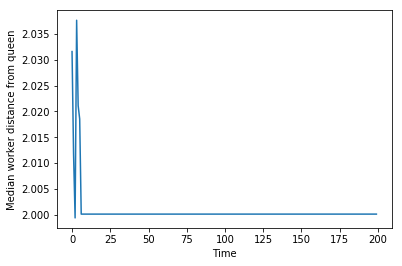

In [38]:
plt.plot(median_distances)
plt.xlabel('Time')
plt.ylabel('Median worker distance from queen')

## Video Stuff

In [40]:
!start .

In [39]:
!convert -delay 25 $config["save_folder"]/t*.png $config.VID_PATH

The system cannot find the file specified.


In [ ]:
VLC = "/Applications/VLC.app/Contents/MacOS/VLC"
!$VLC $config.VID_PATH